## Short-term load-forecasting and Cross-Validation Demo

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from metric_funcs import mape
from sklearn.metrics import mean_squared_error as mse
from forecaster import Forecaster as FC
%matplotlib inline

#### A crucial step in building this model is to define an appropiate cross validation methodology to fine tune it.

Within conventional libraries I couldn't find a cv-methodology that fitted this idea of training multiple independent models at a given time-resolution so I built one (sklearn library does have one although the methodology is different; it aggregates the training data from but the k-sample to k+1 sample,  as opposed to partitioning equally spaced models).

In this case I strive for independent models to avoid training long term trends and seasonalities; __my hypothesis is  that short-term forecasting is more correlated to closer past intervals__ (ie. hours before forecast, 1 day before, 1 week before). In any case, I believe we could test this hypothesis through cross-validation and improve the outcome.

How the implement cross-validation works:

1) Partitions the training set into n tasks given a user-defined resolution to resample the training data (ex. '1W', '3W', '1Y') -- __Its like defining k-folds but instead of k-splits, you provide a time split__.

2) Under the hood it resamples the dataset, retrieves indices and generates n-tasks with equal size. 

3) Then trains-tests on each sample to get a score (in this case I chose MSE from sklearn library).

Note: The last day in each task is used to test that sample as well as to train the next task.

#### 1) Load dataset.

In [40]:
forecaster = FC('../data/train_cleaned.csv')

#### 2) Use cross-val method which takes:

a) an error function to evaluate the testing, b) resampling resolution (spliting) and, c) parameters to initialize the RF Regressor.

In [41]:
print 'Mape scores: ', forecaster.cross_val(mape, '3W', n_estimators = 10, max_features=4)[:5]

Mape scores:  [8.733619782424094, 6.557545639293015, 6.123784267677421, 8.10295064974378, 17.388288443982752]


This method returns a list of forecasting errors where each represents a 1-day forecast at a 15-min interval horizon.

As the result shows, the model is performing relatively poor but we can consider this as a benchmark model. 
The __next natural steps would be to tune and find the best set of parameters, features, training times__, etc.

#### 3) To illustrate this process, lets plot MSE vs. a varying parameter (ie. number of trees, max random parameters per split or training time per task); for this example I will vary the training time on each task.

In [95]:
# Tuning for training time

def tuning(res = '3M'):
    '''
    Tune parameters
    
    Params
    ------
    res: str
        Resolution to resample dataset.
    features: int
        num of max_features parameter to cross-validate.
        
    Return
    ------
    Plot MSE vs. variable
    '''

    error = [] 

    for res in resolutions:
        # Compute the mean MSE.
        RF_e = np.array(forecaster.cross_val(mse, res, max_features = 3))
        error.append(np.median(RF_e))
        
    return error

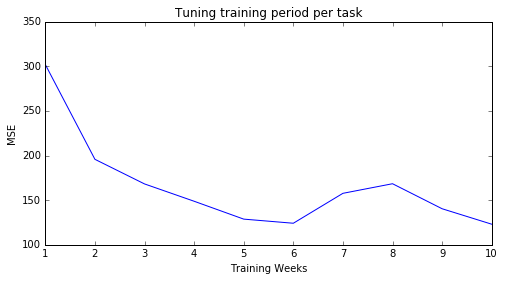

In [113]:
# Plot MSE vs. training time.
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1,1,1)
resolutions = ['1W','2W','3W','4W','5W','6W', '7W', '8W', '9W', '10W']
x = np.linspace(1,len(resolutions), len(resolutions))
ax.plot(x, tuning(resolutions), label = 'MSE')
ax.set_ylabel('MSE')
ax.set_xlabel('Training Weeks')
ax.set_title('Tuning training period per task')

### The model error seems to stabilize at around 5-6 weeks of training, this is a good starting point...